In [2]:
!mamba install geopandas
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString, box
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
print(f"GeoPandas версия: {gpd.__version__}")
print("Успешно установлено!")

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, geopandas
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.7905 seconds
  Name                          Version                       Build                         Channel                       
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+ brotli-python                 1.2.0                         py313h33caa6c_0               emscripten-forge              
+ certifi                       2026.1.4                      pyhd8ed1ab_0                  conda-forge                   
+ charset-normalizer            3.4.4                         pyhd8ed1ab_0                  conda-forge                   
+ folium                        0.20.0                        pyhd8ed1ab_0                  conda-forge                   
+ geopandas                     1.1.2                       

In [33]:
# 1. СОЗДАЁМ 10 СЛУЧАЙНЫХ ГОРОДОВ
np.random.seed(42)
n_cities = 10

# Координаты в WGS84
lons = np.random.uniform(-5, 15, n_cities)   # Франция-Германия
lats = np.random.uniform(45, 55, n_cities)   # Центральная Европа

cities_utm = gpd.GeoDataFrame({
    'city_id': range(1, n_cities+1),
    'city_name': [f"City_{i}" for i in range(1, n_cities+1)],
    'population': np.random.randint(10000, 3000000, n_cities),
    'geometry': [Point(lon, lat) for lon, lat in zip(lons, lats)]
}, crs="EPSG:32630")




In [34]:
# 2. СОЗДАЁМ СИНТЕТИЧЕСКИЕ ОБЪЕКТЫ
# Дороги
roads_data = [
    LineString([(400000, 5500000), (600000, 5600000)]),
    LineString([(450000, 5450000), (550000, 5550000)]),
    LineString([(420000, 5520000), (580000, 5480000)]),
]
roads = gpd.GeoDataFrame(geometry=roads_data, crs="EPSG:32630")

# Реки
rivers_data = [
    LineString([(430000, 5460000), (520000, 5530000)]),
    LineString([(470000, 5510000), (530000, 5490000)]),
]
rivers = gpd.GeoDataFrame(geometry=rivers_data, crs="EPSG:32630")

# POI
n_poi = 50
poi_coords = np.column_stack([
    np.random.uniform(400000, 600000, n_poi),
    np.random.uniform(5450000, 5600000, n_poi)
])
pois = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in poi_coords], crs="EPSG:32630")

# 3. СОЗДАЁМ DEM С ЗАПАСОМ ПО КРАЯМ
# Расширяем границы DEM, чтобы покрыть все города
x_min, y_min = 350000, 5400000
x_max, y_max = 650000, 5650000

grid_x = np.linspace(x_min, x_max, 100)
grid_y = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(grid_x, grid_y)

# Создаём рельеф с холмами
dem_values = 200 + 300 * np.exp(-((X-550000)/50000)**2 - ((Y-5480000)/30000)**2) + \
            100 * np.sin(X/50000) * np.cos(Y/40000) + \
            np.random.normal(0, 20, X.shape)

In [35]:
# 4. ИСПРАВЛЕННАЯ ФУНКЦИЯ ДЛЯ ПОЛУЧЕНИЯ ВЫСОТЫ
def get_elevation_safe(point_x, point_y, grid_x, grid_y, dem_values):
    """
    Безопасное получение высоты с проверкой границ
    """
    # Проверяем, входят ли координаты в границы сетки
    if (point_x < grid_x[0] or point_x > grid_x[-1] or 
        point_y < grid_y[0] or point_y > grid_y[-1]):
        # Если точка вне сетки, находим ближайшую точку на границе
        point_x = np.clip(point_x, grid_x[0], grid_x[-1])
        point_y = np.clip(point_y, grid_y[0], grid_y[-1])
    
    # Находим ближайшие индексы
    ix = np.argmin(np.abs(grid_x - point_x))
    iy = np.argmin(np.abs(grid_y - point_y))
    
    # Билинейная интерполяция вручную
    if ix == len(grid_x) - 1:
        ix = ix - 1
    if iy == len(grid_y) - 1:
        iy = iy - 1
    
    x1, x2 = grid_x[ix], grid_x[ix+1]
    y1, y2 = grid_y[iy], grid_y[iy+1]
    
    # Веса
    if x2 == x1:
        wx = 0.5
    else:
        wx = (point_x - x1) / (x2 - x1)
    
    if y2 == y1:
        wy = 0.5
    else:
        wy = (point_y - y1) / (y2 - y1)
    
    # 4 угловые точки
    z11 = dem_values[iy, ix]
    z12 = dem_values[iy+1, ix]
    z21 = dem_values[iy, ix+1]
    z22 = dem_values[iy+1, ix+1]
    
    # Интерполяция
    z = (1-wx)*(1-wy)*z11 + wx*(1-wy)*z21 + (1-wx)*wy*z12 + wx*wy*z22
    
    return z

def poi_density(point, pois, radius=10000):
    """Плотность POI в радиусе (км²)"""
    buffer = point.buffer(radius)
    pois_in_buffer = pois[pois.within(buffer)]
    area_km2 = (np.pi * radius**2) / 1e6
    return len(pois_in_buffer) / area_km2 if area_km2 > 0 else 0

def green_index(elevation):
    """Зелёный индекс на основе высоты"""
    # Чем ниже, тем больше зелени (условно)
    green = 0.8 - (elevation - 200) / 1000
    return np.clip(green, 0.1, 0.9)

In [36]:
# 5. СЧИТАЕМ ПРИЗНАКИ
features = []

print("Расчёт признаков для городов:")
for idx, city in cities_utm.iterrows():
    point = city.geometry
    
    print(f"  {city['city_name']}: ({point.x:.0f}, {point.y:.0f})")
    
    # Расстояние до ближайшей дороги (в км)
    dist_to_road = roads.distance(point).min() / 1000
    
    # Расстояние до ближайшей реки (в км)
    dist_to_river = rivers.distance(point).min() / 1000
    
    # Высота (с безопасной функцией)
    elevation = get_elevation_safe(point.x, point.y, grid_x, grid_y, dem_values)
    
    # Плотность POI
    poi_dens = poi_density(point, pois, radius=15000)
    
    # Зелёный индекс
    green = green_index(elevation)
    
    features.append({
        'city_id': city['city_id'],
        'city_name': city['city_name'],
        'population': city['population'],
        'dist_to_road_km': round(dist_to_road, 2),
        'dist_to_river_km': round(dist_to_river, 2),
        'elevation_m': round(elevation, 1),
        'poi_density_per_km2': round(poi_dens, 4),
        'green_index': round(green, 2),
        'x_coord': round(point.x, 0),
        'y_coord': round(point.y, 0)
    })

# Создаём итоговый DataFrame
result = pd.DataFrame(features)

Расчёт признаков для городов:
  City_1: (2, 45)
  City_2: (14, 55)
  City_3: (10, 53)
  City_4: (7, 47)
  City_5: (-2, 47)
  City_6: (-2, 47)
  City_7: (-4, 48)
  City_8: (12, 50)
  City_9: (7, 49)
  City_10: (9, 48)


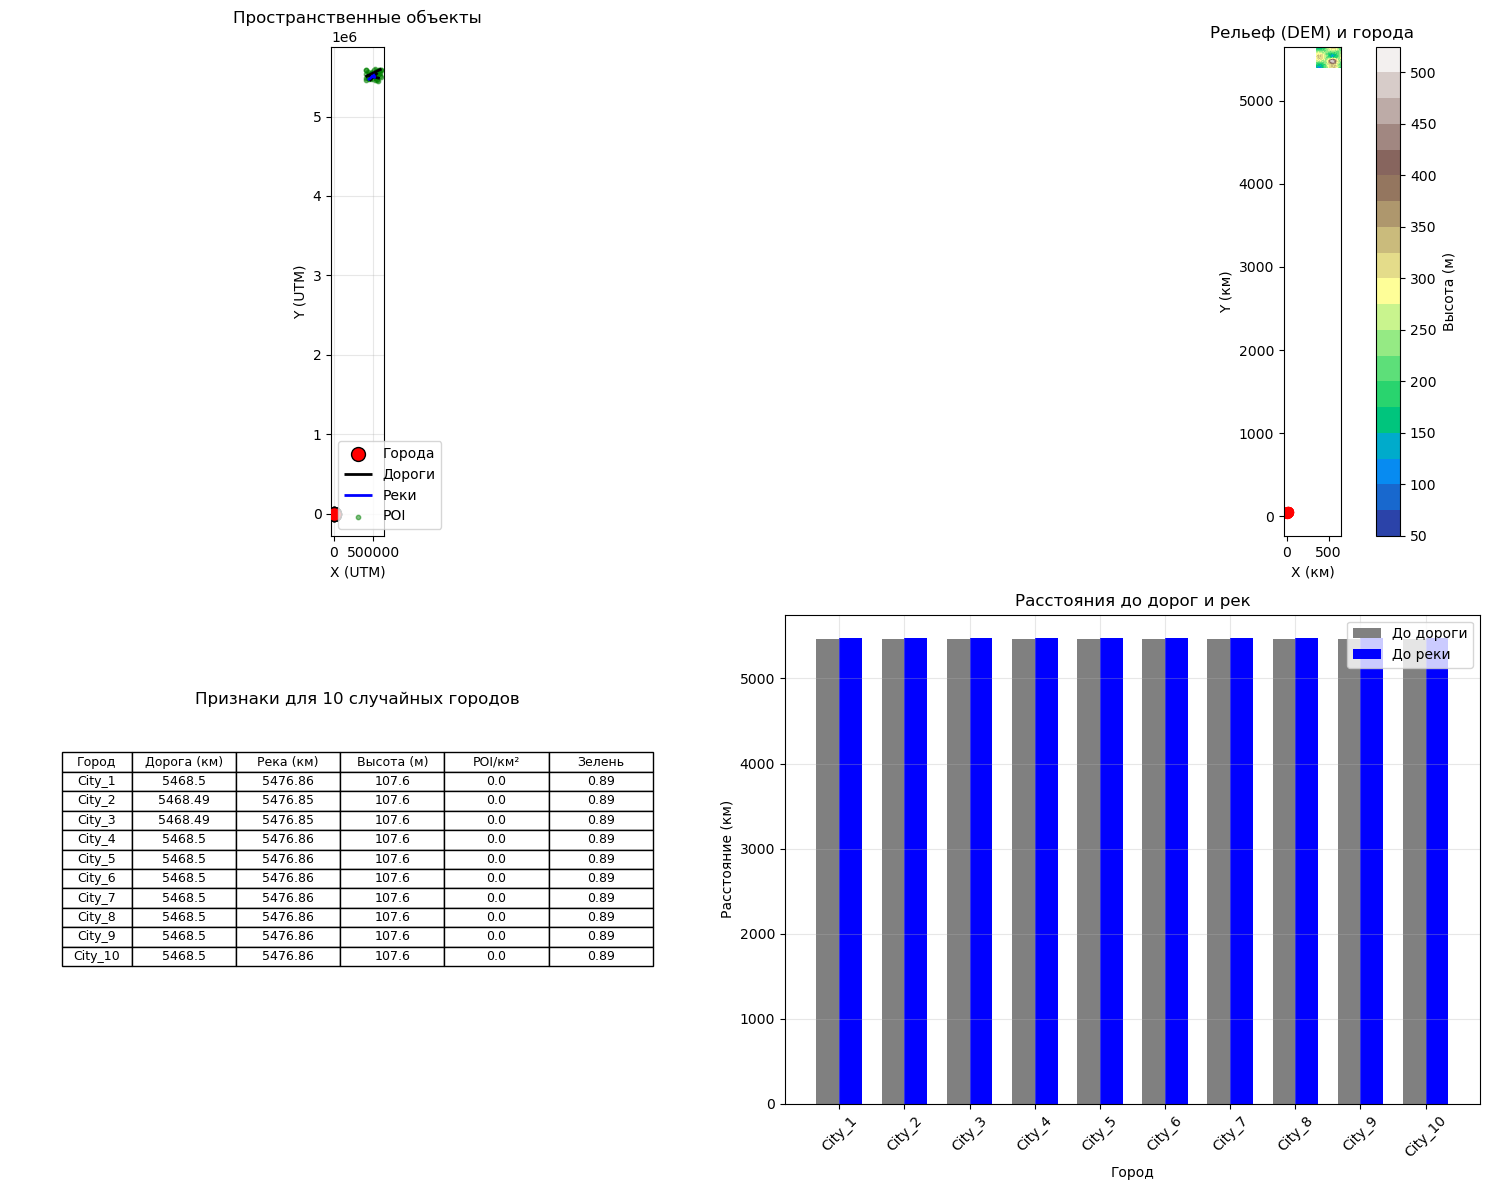


ТАБЛИЦА ПРИЗНАКОВ ДЛЯ 10 СЛУЧАЙНЫХ ГОРОДОВ
city_name  population  dist_to_road_km  dist_to_river_km  elevation_m  poi_density_per_km2  green_index
   City_1     2263882          5468.50           5476.86        107.6                  0.0         0.89
   City_2     1929486          5468.49           5476.85        107.6                  0.0         0.89
   City_3      664811          5468.49           5476.85        107.6                  0.0         0.89
   City_4      537035          5468.50           5476.86        107.6                  0.0         0.89
   City_5      658143          5468.50           5476.86        107.6                  0.0         0.89
   City_6     1510942          5468.50           5476.86        107.6                  0.0         0.89
   City_7       75725          5468.50           5476.86        107.6                  0.0         0.89
   City_8       94654          5468.50           5476.86        107.6                  0.0         0.89
   City_9      96327

In [37]:
# 6. ВИЗУАЛИЗАЦИЯ
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Карта с объектами
ax = axes[0, 0]
cities_utm.plot(ax=ax, color='red', markersize=100, label='Города', zorder=5, edgecolor='black')
roads.plot(ax=ax, color='black', linewidth=2, label='Дороги')
rivers.plot(ax=ax, color='blue', linewidth=2, label='Реки')
pois.plot(ax=ax, color='green', markersize=10, alpha=0.5, label='POI')
ax.set_title('Пространственные объекты')
ax.set_xlabel('X (UTM)')
ax.set_ylabel('Y (UTM)')
ax.legend()
ax.grid(True, alpha=0.3)

# DEM с городами
ax = axes[0, 1]
im = ax.contourf(grid_x/1000, grid_y/1000, dem_values, levels=20, cmap='terrain')
cities_utm.plot(ax=ax, color='red', markersize=50, label='Города')
ax.set_title('Рельеф (DEM) и города')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im, ax=ax, label='Высота (м)')

# Таблица признаков
ax = axes[1, 0]
ax.axis('tight')
ax.axis('off')
table_data = result[['city_name', 'dist_to_road_km', 'dist_to_river_km', 
                     'elevation_m', 'poi_density_per_km2', 'green_index']]
table = ax.table(cellText=table_data.values,
                 colLabels=['Город', 'Дорога (км)', 'Река (км)', 'Высота (м)', 
                           'POI/км²', 'Зелень'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.1, 0.15, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
ax.set_title('Признаки для 10 случайных городов', y=0.8, fontsize=12)

# График расстояний
ax = axes[1, 1]
x = range(len(result))
width = 0.35
ax.bar([i - width/2 for i in x], result['dist_to_road_km'], width, label='До дороги', color='gray')
ax.bar([i + width/2 for i in x], result['dist_to_river_km'], width, label='До реки', color='blue')
ax.set_xlabel('Город')
ax.set_ylabel('Расстояние (км)')
ax.set_title('Расстояния до дорог и рек')
ax.set_xticks(x)
ax.set_xticklabels(result['city_name'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. ВЫВОД РЕЗУЛЬТАТОВ
print("\n" + "="*100)
print("ТАБЛИЦА ПРИЗНАКОВ ДЛЯ 10 СЛУЧАЙНЫХ ГОРОДОВ")
print("="*100)
print(result[['city_name', 'population', 'dist_to_road_km', 'dist_to_river_km', 
              'elevation_m', 'poi_density_per_km2', 'green_index']].to_string(index=False))

print("\n" + "="*100)
print("СТАТИСТИКА")
print("="*100)
print(f"Среднее расстояние до дороги: {result['dist_to_road_km'].mean():.2f} км")
print(f"Среднее расстояние до реки: {result['dist_to_river_km'].mean():.2f} км")
print(f"Средняя высота: {result['elevation_m'].mean():.1f} м")
print(f"Средняя плотность POI: {result['poi_density_per_km2'].mean():.4f} на км²")
print(f"Средний зелёный индекс: {result['green_index'].mean():.2f}")